In [ ]:
"""
https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery

The dataset consists of aerial imagery of Dubai obtained by MBRSC satellites and annotated with pixel-wise semantic segmentation in 6 classes. The total volume of the dataset is 72 images grouped into 6 larger tiles. The classes are:

Building: #3C1098
Land (unpaved area): #8429F6
Road: #6EC1E4
Vegetation: #FEDD3A
Water: #E2A929
Unlabeled: #9B9B9B

Use patchify....
Tile 1: 797 x 644 --> 768 x 512 --> 6
Tile 2: 509 x 544 --> 512 x 256 --> 2
Tile 3: 682 x 658 --> 512 x 512  --> 4
Tile 4: 1099 x 846 --> 1024 x 768 --> 12
Tile 5: 1126 x 1058 --> 1024 x 1024 --> 16
Tile 6: 859 x 838 --> 768 x 768 --> 9
Tile 7: 1817 x 2061 --> 1792 x 2048 --> 56
Tile 8: 2149 x 1479 --> 1280 x 2048 --> 40
Total 9 images in each folder * (145 patches) = 1305
Total 1305 patches of size 256x256

"""

In [ ]:
!pip install patchify
!pip install kaggle

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

!pip install --upgrade efficientnet
!pip install --upgrade segmentation-models
!pip install --upgrade tensorflow keras

In [4]:
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [5]:
import os
import re
import cv2
from skimage import io
import numpy as np
import random
from PIL import Image
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from matplotlib import pyplot as plt
from segmentation_models import Unet
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [6]:
# Mount Google Drive
drive.mount('/content/drive')

# Define the path where you want to save the data in Google Drive
save_path = '/content/drive/My Drive/semantic_segmentation_data/'

# Ensure that the save_path directory exists
if not os.path.exists(save_path):
    os.makedirs(save_path)

Mounted at /content/drive


In [7]:
# Define the patch size
patch_size = 256
root_directory = 'Semantic segmentation dataset/'
scaler = MinMaxScaler()

In [8]:
def load_images(root_directory, patch_size, scaler):
    image_dataset = []

    for tile_folder in os.listdir(root_directory):
        tile_path = os.path.join(root_directory, tile_folder)

        if not os.path.isdir(tile_path):
            continue

        image_folder = os.path.join(tile_path, 'images')
        if not os.path.exists(image_folder):
            continue

        # Sort image files based on numeric part of file name
        image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.jpg')], key=lambda x: int(re.search(r'\d+', x).group()))

        for image_name in image_files:
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path, 1)  # Read each image as BGR
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            SIZE_X = (image.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
            SIZE_Y = (image.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
            image = Image.fromarray(image)
            image = image.crop((0, 0, SIZE_X, SIZE_Y)) # Crop from top left corner
            image = np.array(image)

            # Extract patches from each image
            print("Now patchifying image:", image_path)
            patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap

            for i in range(patches_img.shape[0]):
                for j in range(patches_img.shape[1]):
                    single_patch_img = patches_img[i, j, :, :]

                    # Use minmaxscaler instead of just dividing by 255.
                    single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)

                    # single_patch_img = (single_patch_img.astype('float32')) / 255.
                    single_patch_img = single_patch_img[0]  # Drop the extra unnecessary dimension that patchify adds.
                    image_dataset.append(single_patch_img)

    return np.array(image_dataset)

def load_masks(root_directory, patch_size):
    mask_dataset = []

    for tile_folder in os.listdir(root_directory):
        tile_path = os.path.join(root_directory, tile_folder)

        if not os.path.isdir(tile_path):
            continue

        mask_folder = os.path.join(tile_path, 'masks')
        if not os.path.exists(mask_folder):
            continue

        # Sort mask files based on numeric part of file name
        mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith('.png')], key=lambda x: int(re.search(r'\d+', x).group()))

        for mask_name in mask_files:
            mask_path = os.path.join(mask_folder, mask_name)
            mask = cv2.imread(mask_path, 1)  # Read each image as BGR
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            SIZE_X = (mask.shape[1] // patch_size) * patch_size  # Nearest size divisible by our patch size
            SIZE_Y = (mask.shape[0] // patch_size) * patch_size  # Nearest size divisible by our patch size
            mask = Image.fromarray(mask)
            mask = mask.crop((0, 0, SIZE_X, SIZE_Y))  # Crop from top left corner
            mask = np.array(mask)

            # Extract patches from each mask
            print("Now patchifying mask:", mask_path)
            patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)  # Step=256 for 256 patches means no overlap

            for i in range(patches_mask.shape[0]):
                for j in range(patches_mask.shape[1]):
                    single_patch_mask = patches_mask[i, j, :, :]
                    # single_patch_mask = (single_patch_mask.astype('float32')) / 255. # No need to scale masks, but you can do it if you want
                    single_patch_mask = single_patch_mask[0]  # Drop the extra unnecessary dimension that patchify adds.
                    mask_dataset.append(single_patch_mask)

    return np.array(mask_dataset)

In [9]:
# Function to load datasets
def load_dataset(file_name):
    file_path = os.path.join(save_path, file_name)
    if os.path.exists(file_path):
        return np.load(file_path)
    else:
        print(f"File '{file_name}' not found in '{data_path}'.")
        return None

# Check if dataset has already been downloaded
if not os.path.exists(os.path.join(save_path, 'image_dataset.npy')) or not os.path.exists(os.path.join(save_path, 'mask_dataset.npy')):
    # Move kaggle.json file from Google Drive to the appropriate directory
    !mkdir -p ~/.kaggle
    !cp '/content/drive/My Drive/kaggle.json' ~/.kaggle/

    # Set permissions
    !chmod 600 ~/.kaggle/kaggle.json

    # Download dataset from Kaggle
    zip_file_path = 'semantic-segmentation-of-aerial-imagery.zip'

    if not os.path.exists(zip_file_path):
        # Download the zip file
        !kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery
        print("Downloading semantic-segmentation-of-aerial-imagery.zip...")
    else:
        print("semantic-segmentation-of-aerial-imagery.zip already exists.")

    # Unzip the downloaded dataset
    !unzip -q semantic-segmentation-of-aerial-imagery.zip

    image_dataset = load_images(root_directory, patch_size, scaler)
    mask_dataset = load_masks(root_directory, patch_size)

    # Save the preprocessed data to Google Drive
    if len(image_dataset) > 0:
        np.save(save_path + 'image_dataset.npy', image_dataset)
        print("Image dataset saved successfully.")
    else:
        print("Image dataset is empty. Saving aborted.")

    if len(mask_dataset) > 0:
        np.save(save_path + 'mask_dataset.npy', mask_dataset)
        print("Mask dataset saved successfully.")
    else:
        print("Mask dataset is empty. Saving aborted.")
else:
    # Load datasets if available
    image_dataset = load_dataset('image_dataset.npy')
    mask_dataset = load_dataset('mask_dataset.npy')

    # Check if datasets were loaded successfully
    if image_dataset is not None and mask_dataset is not None:
        print("Datasets loaded successfully.")
    else:
        print("Unable to load datasets. Please make sure the .npy files exist in the specified directory.")

Datasets loaded successfully.


In [14]:
# Define class titles and colors
class_colors = {
    "Water": "#50E3C2",
    "Land (unpaved area)": "#F5A623",
    "Road": "#DE597F",
    "Building": "#D0021B",
    "Vegetation": "#417505",
    "Unlabeled": "#9B9B9B"
}

# Create a legend using matplotlib patches
patches = [plt.Rectangle((0, 0), 1, 1, color=color, label=label) for label, color in class_colors.items()]

# Plot the legend
plt.figure(figsize=(8, 4))
plt.legend(handles=patches, loc='center', fontsize='large')
plt.axis('off')
plt.title('Segmentation Color Map')
plt.show()

#Sanity check, view few mages
#image_number = random.randint(0, len(image_dataset))
image_number=6
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

# Select the first 16 images
images_to_display = image_dataset[:16]

# Calculate the number of rows and columns for the grid
num_rows = 4
num_cols = 4

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image
for i, image in enumerate(images_to_display):
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

# Show the plot
plt.tight_layout()
plt.show()

# Select the first 16 masks
masks_to_display = mask_dataset[:16]

# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each image
for i, image in enumerate(masks_to_display):
    ax = axes[i]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(f'Image {i+1}')

# Show the plot
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
"""
Calculating RGB from HEX: #3C1098
3C = 3*16 + 12 = 60
10 = 1*16 + 0 = 16
98 = 9*16 + 8 = 152
"""

#Convert HEX to RGB array
#Do the same for all RGB channels in each hex code to convert to RGB
Building = '#3C1098'.lstrip('#')
Building = np.array(tuple(int(Building[i:i+2], 16) for i in (0, 2, 4))) # 60, 16, 152

Land = '#8429F6'.lstrip('#')
Land = np.array(tuple(int(Land[i:i+2], 16) for i in (0, 2, 4))) #132, 41, 246

Road = '#6EC1E4'.lstrip('#')
Road = np.array(tuple(int(Road[i:i+2], 16) for i in (0, 2, 4))) #110, 193, 228

Vegetation =  'FEDD3A'.lstrip('#')
Vegetation = np.array(tuple(int(Vegetation[i:i+2], 16) for i in (0, 2, 4))) #254, 221, 58

Water = 'E2A929'.lstrip('#')
Water = np.array(tuple(int(Water[i:i+2], 16) for i in (0, 2, 4))) #226, 169, 41

Unlabeled = '#9B9B9B'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #155, 155, 155

In [16]:
print(Vegetation)

[254 221  58]


In [17]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Building,axis=-1)] = 0
    label_seg [np.all(label==Land,axis=-1)] = 1
    label_seg [np.all(label==Road,axis=-1)] = 2
    label_seg [np.all(label==Vegetation,axis=-1)] = 3
    label_seg [np.all(label==Water,axis=-1)] = 4
    label_seg [np.all(label==Unlabeled,axis=-1)] = 5

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))


Unique labels in label dataset are:  [0 1 2 3 4 5]


In [18]:
print(mask_dataset.shape)
print(labels.shape)
#labels

(1305, 256, 256, 3)
(1305, 256, 256, 1)


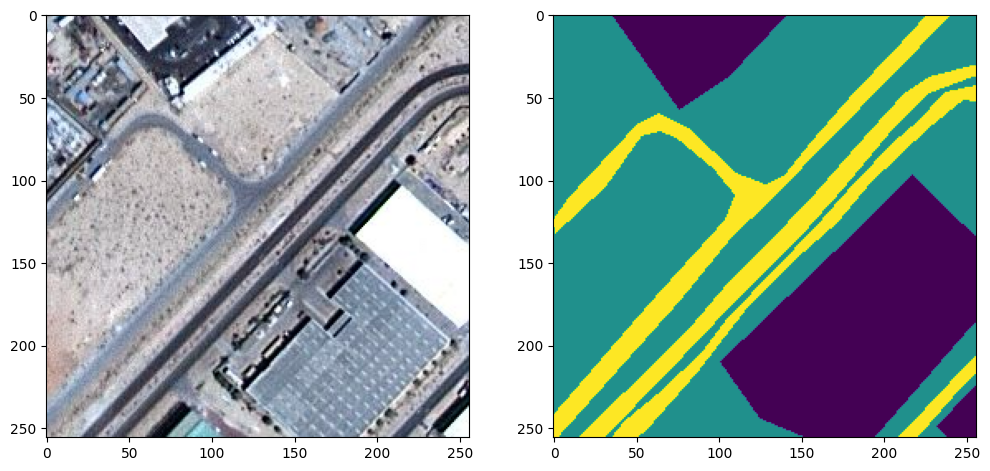

In [20]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [21]:
# One Hot Encoding
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [22]:
labels_cat.shape
#labels_cat

(1305, 256, 256, 6)

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import EarlyStopping

def jaccard_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
    jac = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return jac

# Define metrics including Jaccard coefficient
metrics = ['accuracy', jaccard_coef]

# One-hot encode the labels
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# Create a new optimizer instance
optimizer = Adam(learning_rate=0.001)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# Define a learning rate scheduler function
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 40, etc. epochs.
    """
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.1
    elif epoch > 30:
        lr *= 0.1
    elif epoch > 40:
        lr *= 0.1
    return lr

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define the backbone for the model
BACKBONE = 'resnet34'

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)

# Load the pre-trained model with the specified backbone
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# Compile the model with optimizer, loss, and metrics
model_resnet_backbone.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Preprocess input data
X_train_prepr = sm.get_preprocessing(BACKBONE)(X_train)
X_test_prepr = sm.get_preprocessing(BACKBONE)(X_test)

# Train the model with learning rate scheduler and early stopping
history = model_resnet_backbone.fit(X_train_prepr,
                                    y_train,
                                    batch_size=16,
                                    epochs=100,  # Example maximum number of epochs
                                    verbose=1,
                                    validation_data=(X_test_prepr, y_test),
                                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 60s 365ms/step - accuracy: 0.6002 - jaccard_coef: 0.3065 - loss: 0.9812 - val_accuracy: 0.1389 - val_jaccard_coef: 0.1092 - val_loss: 1.5674 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.7939 - jaccard_coef: 0.5967 - loss: 0.9291 - val_accuracy: 0.0977 - val_jaccard_coef: 0.0743 - val_loss: 1.1216 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.8159 - jaccard_coef: 0.6400 - loss: 0.9211 - val_accuracy: 0.5478 - val_jaccard_coef: 0.4419 - val_loss: 1.0748 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8205 - jaccard_coef: 0.6471 - loss: 0.9180 - val_accuracy: 0.5478 - val_jaccard_coef: 0.4450 - val_loss: 1.0815 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.8379 - jaccard_coef: 0.6741 - loss: 0.9132 - val_accuracy: 0.5478 - val_jaccard_coef: 0.4570 - val_loss: 1.1008 - learning_r

In [26]:
#LinkNet
# Load the pre-trained model with the specified backbone
model_linknet_backbone = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# Create a new optimizer instance
optimizer = Adam(learning_rate=0.001)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# Define a learning rate scheduler function
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 40, etc. epochs.
    """
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.1
    elif epoch > 30:
        lr *= 0.1
    elif epoch > 40:
        lr *= 0.1
    return lr

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with optimizer, loss, and metrics
model_linknet_backbone.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Train the model
history_linknet = model_linknet_backbone.fit(X_train_prepr,
                                    y_train,
                                    batch_size=16,
                                    epochs=100,  # Example maximum number of epochs
                                    verbose=1,
                                    validation_data=(X_test_prepr, y_test),
                                    callbacks=[lr_scheduler, early_stopping])


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 75s 443ms/step - accuracy: 0.5357 - jaccard_coef: 0.2710 - loss: 0.9918 - val_accuracy: 0.1075 - val_jaccard_coef: 0.0602 - val_loss: 1.3310 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 6s 83ms/step - accuracy: 0.7736 - jaccard_coef: 0.5736 - loss: 0.9339 - val_accuracy: 0.1674 - val_jaccard_coef: 0.1152 - val_loss: 1.0854 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.7732 - jaccard_coef: 0.5823 - loss: 0.9339 - val_accuracy: 0.5446 - val_jaccard_coef: 0.4582 - val_loss: 1.2806 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8035 - jaccard_coef: 0.6273 - loss: 0.9239 - val_accuracy: 0.5466 - val_jaccard_coef: 0.4615 - val_loss: 1.2809 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - accuracy: 0.8250 - jaccard_coef: 0.6545 - loss: 0.9191 - val_accuracy: 0.5325 - val_jaccard_coef: 0.4395 - val_loss: 1.2824 - learning_r

In [27]:
# FPN
# Load the pre-trained model with the specified backbone
model_fpn_backbone = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

# Create a new optimizer instance
optimizer = Adam(learning_rate=0.001)

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1)

# Define a learning rate scheduler function
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 10, 20, 30, 40, etc. epochs.
    """
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.1
    elif epoch > 30:
        lr *= 0.1
    elif epoch > 40:
        lr *= 0.1
    return lr

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with optimizer, loss, and metrics
model_fpn_backbone.compile(optimizer=optimizer, loss=total_loss, metrics=metrics)

# Train the model
history_fpn = model_fpn_backbone.fit(X_train_prepr,
                                    y_train,
                                    batch_size=16,
                                    epochs=100,  # Example maximum number of epochs
                                    verbose=1,
                                    validation_data=(X_test_prepr, y_test),
                                    callbacks=[lr_scheduler, early_stopping])

Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 91s 609ms/step - accuracy: 0.6468 - jaccard_coef: 0.4729 - loss: 0.9630 - val_accuracy: 0.1389 - val_jaccard_coef: 0.1091 - val_loss: 1.5285 - learning_rate: 0.0010
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 179ms/step - accuracy: 0.8045 - jaccard_coef: 0.6258 - loss: 0.9243 - val_accuracy: 0.5252 - val_jaccard_coef: 0.2273 - val_loss: 1.0297 - learning_rate: 0.0010
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.8171 - jaccard_coef: 0.6469 - loss: 0.9178 - val_accuracy: 0.1389 - val_jaccard_coef: 0.1091 - val_loss: 1.5743 - learning_rate: 0.0010
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.7929 - jaccard_coef: 0.6044 - loss: 0.9284 - val_accuracy: 0.1405 - val_jaccard_coef: 0.1093 - val_loss: 1.4670 - learning_rate: 0.0010
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 12s 180ms/step - accuracy: 0.8333 - jaccard_coef: 0.6715 - loss: 0.9120 - val_accuracy: 0.5478 - val_jaccard_coef: 0.4573 - val_loss: 1.1035 - le

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import MeanIoU

def plot_metrics_side_by_side(history_list, model_names):
    # Define contrasting colors
    colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink']

    # Plot training and validation loss for all models
    plt.figure(figsize=(15, 5))
    for i, history in enumerate(history_list):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(1, len(loss) + 1)
        plt.plot(epochs, loss, label=f'{model_names[i]} Training loss', color=colors[i], linewidth=2)
        plt.plot(epochs, val_loss, label=f'{model_names[i]} Validation loss', linestyle='--', color=colors[i], linewidth=2)

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation IoU for all models
    if all('jaccard_coef' in history.history for history in history_list):
        plt.figure(figsize=(15, 5))
        for i, history in enumerate(history_list):
            iou = history.history['jaccard_coef']
            val_iou = history.history['val_jaccard_coef']
            epochs = range(1, len(iou) + 1)
            plt.plot(epochs, iou, label=f'{model_names[i]} Training IoU', color=colors[i], linewidth=2)
            plt.plot(epochs, val_iou, label=f'{model_names[i]} Validation IoU', linestyle='--', color=colors[i], linewidth=2)

        plt.title('Training and Validation IoU')
        plt.xlabel('Epochs')
        plt.ylabel('IoU')
        plt.legend()
        plt.show()

    else:
        print("Jaccard coefficient (IoU) not recorded during training.")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.metrics import MeanIoU

# Dictionary to map labels to classes
label_to_class = {
    "Building": 0,
    "Land": 1,
    "Road": 2,
    "Vegetation": 3,
    "Water": 4,
    "Unlabeled": 5
}

def compare_iou(model_list, model_names, X_test, y_test):
    n_classes = len(label_to_class)
    data = []

    for model, name in zip(model_list, model_names):
        # Predict on test set
        y_pred = model.predict(X_test)
        y_pred_argmax = np.argmax(y_pred, axis=3)
        y_test_argmax = np.argmax(y_test, axis=3)

        # Calculate confusion matrix
        cm = confusion_matrix(y_test_argmax.flatten(), y_pred_argmax.flatten())

        # Calculate IoU for each class
        iou_per_class = np.diag(cm) / (np.sum(cm, axis=1) + np.sum(cm, axis=0) - np.diag(cm))

        # Calculate mean IoU
        IOU_keras = MeanIoU(num_classes=n_classes)
        IOU_keras.update_state(y_test_argmax, y_pred_argmax)
        mean_iou = IOU_keras.result().numpy()

        # Append data to list
        data.append((name, mean_iou, iou_per_class))

    # Plot bar graph
    plt.figure(figsize=(10, 6))
    x = np.arange(n_classes)

    for i, (name, mean_iou, iou_per_class) in enumerate(data):
        plt.bar(x + i * 0.2, iou_per_class, width=0.2, label=f"{name} (Mean IoU: {mean_iou:.4f})")

    plt.xlabel('Class')
    plt.ylabel('IoU')
    plt.title('IoU per Class')
    plt.xticks(x + 0.2, [f"{label} (Class {class_num})" for label, class_num in label_to_class.items()])
    plt.legend()
    plt.tight_layout()
    plt.show()


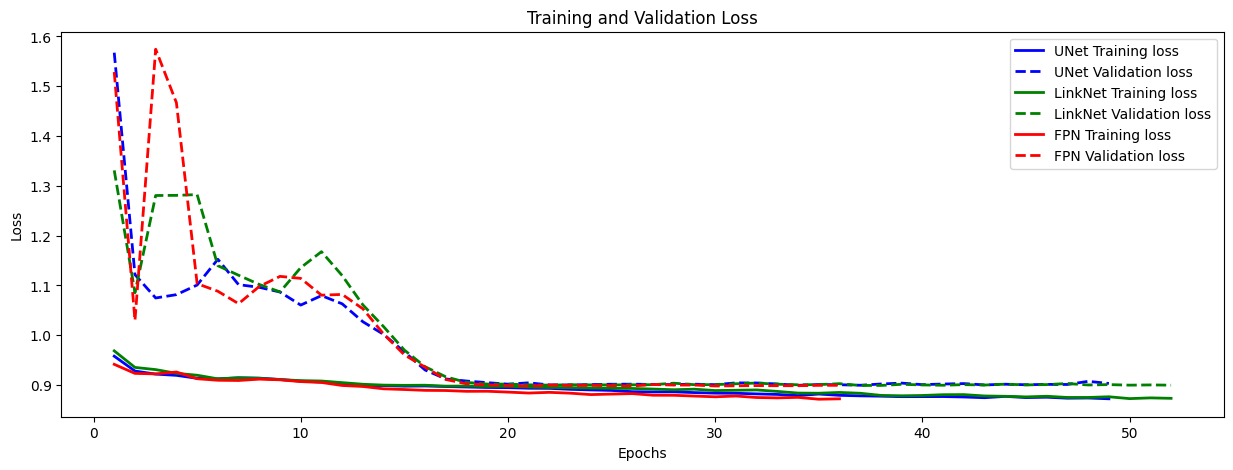

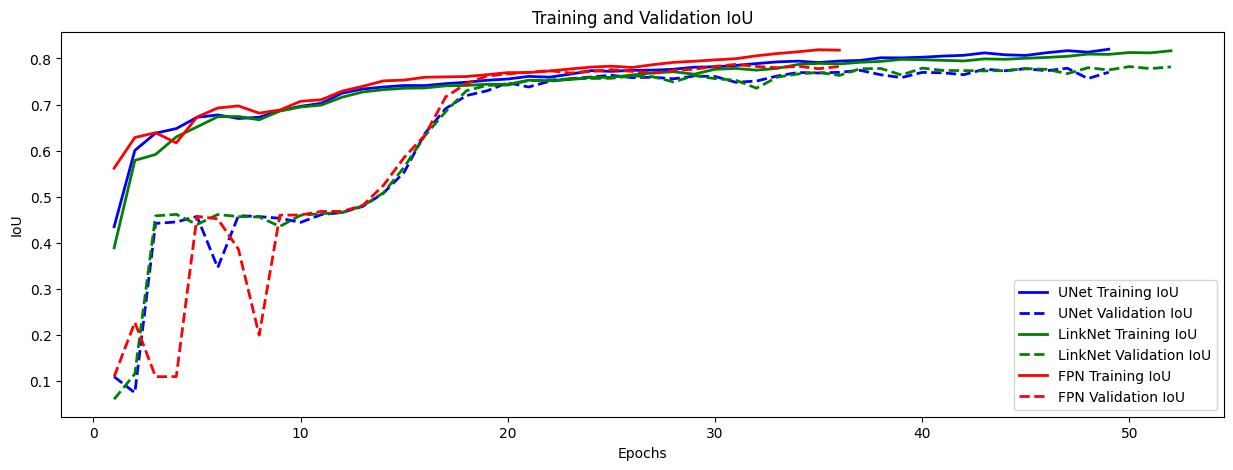

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 373ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


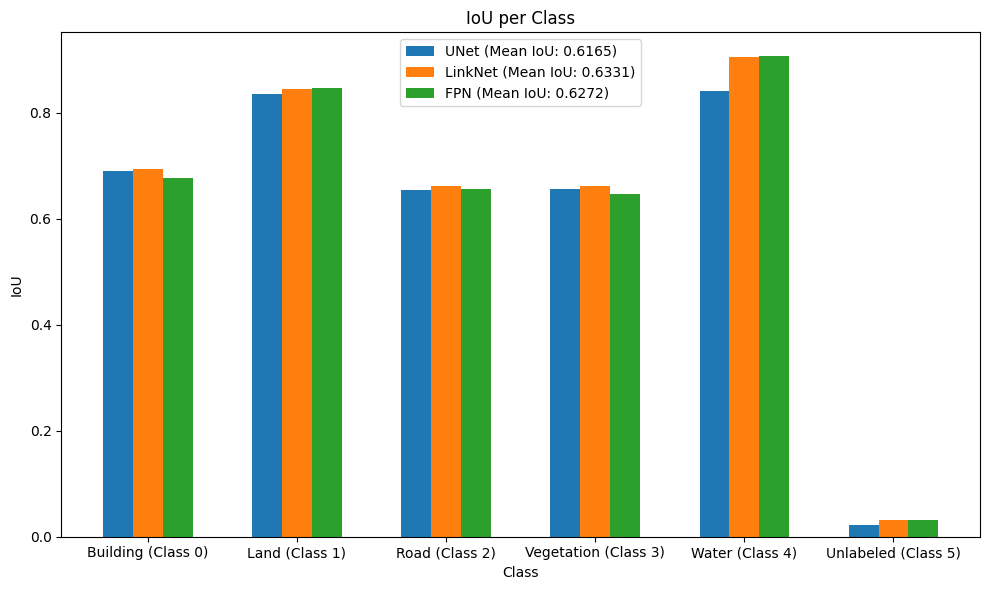

In [32]:
# Assuming you have history objects for each model: history_resnet, history_linknet, history_fpn
# Assuming you have trained models: model_resnet_backbone, model_linknet_backbone, model_fpn_backbone

history_list = [history, history_linknet, history_fpn]

model_list = [model_resnet_backbone, model_linknet_backbone, model_fpn_backbone]

model_names = ['UNet', 'LinkNet', 'FPN']


# Plot training and validation loss side by side
plot_metrics_side_by_side(history_list, model_names)

# Compare IoU metrics
compare_iou(model_list, model_names, X_test, y_test)




1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 997ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


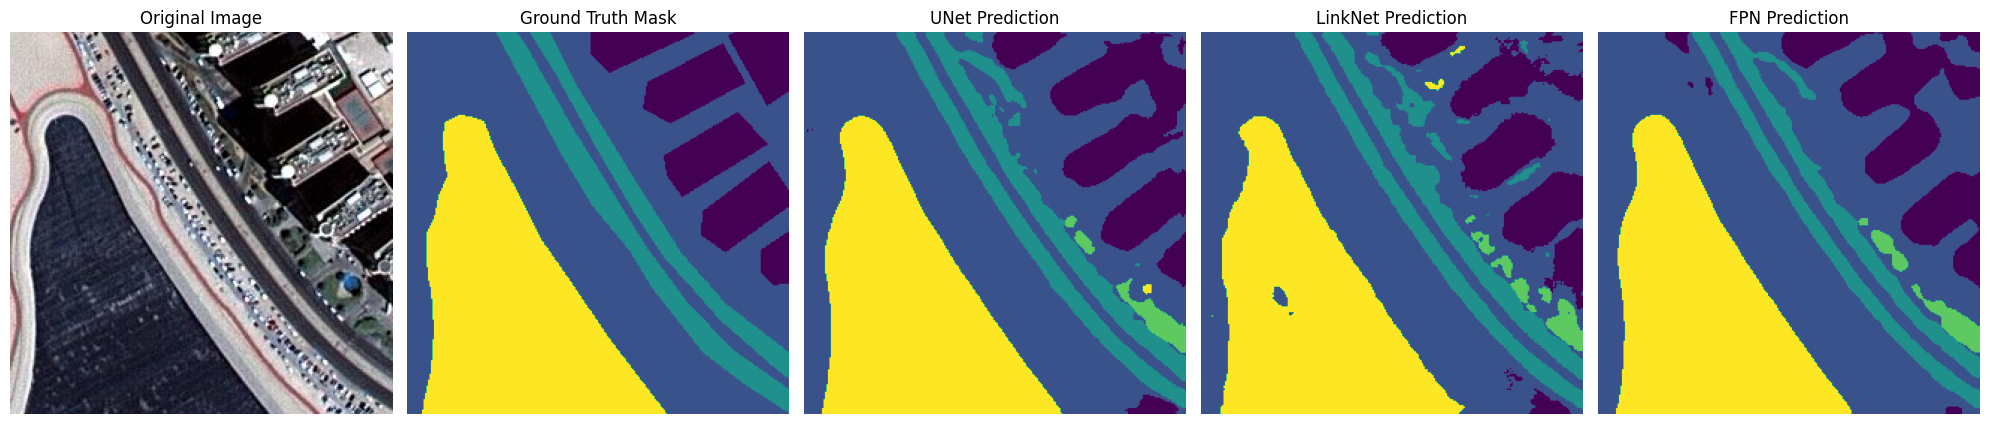

In [33]:
# Assuming you have three models in model_list and their corresponding names in model_names
models = model_list[:3]  # Select the first three models from your list
model_names = model_names[:3]  # Select the names of the first three models

# Assuming you have a single test image and its corresponding ground truth mask
test_img_number = random.randint(0, len(X_test) - 1)
test_img = X_test[test_img_number]
ground_truth_mask = y_test[test_img_number]

# Display the original image
plt.figure(figsize=(20, 5))

plt.subplot(1, 5, 1)
plt.title('Original Image')
plt.imshow(test_img)
plt.axis('off')  # Turn off axis labels

# Display the ground truth mask
plt.subplot(1, 5, 2)
plt.title('Ground Truth Mask')
ground_truth_label = np.argmax(ground_truth_mask, axis=2)
plt.imshow(ground_truth_label, cmap='viridis')  # Displaying the ground truth mask
plt.axis('off')  # Turn off axis labels

# Predict and display the output of each model
for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
    prediction = model.predict(np.expand_dims(test_img, 0))
    predicted_label = np.argmax(prediction[0], axis=2)

    plt.subplot(1, 5, i + 2)
    plt.title(f'{model_name} Prediction')
    plt.imshow(predicted_label, cmap='viridis')  # Displaying the predicted class labels
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step


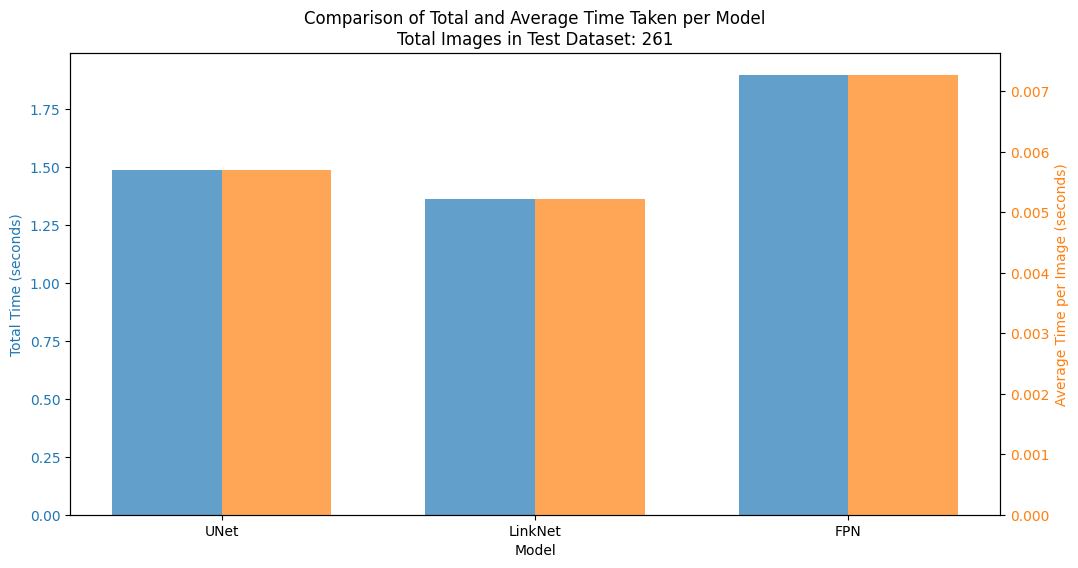

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Define your model_list and model_names
model_list = [model_resnet_backbone, model_linknet_backbone, model_fpn_backbone]
model_names = ['UNet', 'LinkNet', 'FPN']

# Assuming you have X_test, the test dataset

# Initialize lists to store total time taken and average time taken per image for each model
total_times = []
average_times = []

# Iterate through each model
for model, name in zip(model_list, model_names):
    start_time = time.time()
    # Predict on test set
    y_pred = model.predict(X_test)
    end_time = time.time()

    # Calculate total time taken
    total_time = end_time - start_time
    total_times.append(total_time)

    # Calculate average time taken per image
    num_images = len(X_test)
    average_time_per_image = total_time / num_images
    average_times.append(average_time_per_image)

# Visualize the results in a chart
fig, ax1 = plt.subplots(figsize=(12, 6))

# Calculate bar positions
bar_width = 0.35
x = np.arange(len(model_names))

# Plot total time bars
total_color = '#1f77b4'  # blue
total_bar = ax1.bar(x - bar_width/2, total_times, width=bar_width, color=total_color, alpha=0.7, label='Total Time')

# Set up the primary y-axis for total time
ax1.set_xlabel('Model')
ax1.set_ylabel('Total Time (seconds)', color=total_color)
ax1.tick_params(axis='y', labelcolor=total_color)
ax1.set_xticks(x)
ax1.set_xticklabels(model_names)

# Create a secondary y-axis for average time per image
ax2 = ax1.twinx()

# Plot average time bars
average_color = '#ff7f0e'  # orange
average_bar = ax2.bar(x + bar_width/2, average_times, width=bar_width, color=average_color, alpha=0.7, label='Average Time per Image')

ax2.set_ylabel('Average Time per Image (seconds)', color=average_color)
ax2.tick_params(axis='y', labelcolor=average_color)

# Add title with total image count
total_images = len(X_test)
plt.title(f'Comparison of Total and Average Time Taken per Model\nTotal Images in Test Dataset: {total_images}')

plt.show()


In [49]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score

# Define a function to calculate Mean IOU
def calculate_mean_iou(ground_truth, predicted):
    intersection = np.logical_and(ground_truth, predicted)
    union = np.logical_or(ground_truth, predicted)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

# Initialize lists to store Mean IOU for each model
mean_iou_unet = []
mean_iou_linknet = []
mean_iou_fpn = []

# Set up figure for displaying images
plt.figure(figsize=(20, 50))

# Loop through 10 rows
for row in range(10):
    # Select a random image from the test dataset
    test_img_number = random.randint(0, len(X_test) - 1)
    test_img = X_test[test_img_number]
    ground_truth_mask = y_test[test_img_number]

    # Display the original image
    plt.subplot(10, 5, row*5 + 1)
    plt.title('Original Image')
    plt.imshow(test_img)
    plt.axis('off')

    # Display the ground truth mask
    plt.subplot(10, 5, row*5 + 2)
    plt.title('Ground Truth Mask')
    ground_truth_label = np.argmax(ground_truth_mask, axis=2)
    plt.imshow(ground_truth_label, cmap='viridis')
    plt.axis('off')

    # Predict and display the output of each model
    best_iou_model_name = None
    best_iou = -1
    for i, (model, model_name) in enumerate(zip(models, model_names), start=1):
        prediction = model.predict(np.expand_dims(test_img, 0))
        predicted_label = np.argmax(prediction[0], axis=2)

        # Calculate Mean IOU for the model
        mean_iou = calculate_mean_iou(ground_truth_label, predicted_label)
        if model_name == 'UNet':
            mean_iou_unet.append(mean_iou)
        elif model_name == 'LinkNet':
            mean_iou_linknet.append(mean_iou)
        elif model_name == 'FPN':
            mean_iou_fpn.append(mean_iou)

        # Display the predicted class labels
        plt.subplot(10, 5, row*5 + 2 + i)
        plt.title(f'{model_name} Prediction\nMean IOU: {mean_iou:.4f}')
        plt.imshow(predicted_label, cmap='viridis')
        plt.axis('off')

        # Highlight the image with a border if it has the highest IoU
        if mean_iou > best_iou:
            best_iou = mean_iou
            best_iou_model_name = model_name
            plt.gca().spines['top'].set_color('green')
            plt.gca().spines['right'].set_color('green')
            plt.gca().spines['bottom'].set_color('green')
            plt.gca().spines['left'].set_color('green')
            plt.gca().spines['top'].set_linewidth(3)
            plt.gca().spines['right'].set_linewidth(3)
            plt.gca().spines['bottom'].set_linewidth(3)
            plt.gca().spines['left'].set_linewidth(3)

# Calculate Mean IOU for each model across all images
mean_iou_unet_avg = np.mean(mean_iou_unet)
mean_iou_linknet_avg = np.mean(mean_iou_linknet)
mean_iou_fpn_avg = np.mean(mean_iou_fpn)

# Print Mean IOU for each model
print(f'Mean IOU for UNet across all images: {mean_iou_unet_avg:.4f}')
print(f'Mean IOU for LinkNet across all images: {mean_iou_linknet_avg:.4f}')
print(f'Mean IOU for FPN across all images: {mean_iou_fpn_avg:.4f}')

Output hidden; open in https://colab.research.google.com to view.